In [183]:
import numpy as np
import pandas as pd
import time

from sklearn.datasets import fetch_covtype
from sklearn.metrics import log_loss
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 16

In [184]:
covtype = fetch_covtype()
y = covtype.target

pd.Series(y).value_counts(sort=False)

1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
dtype: int64

In [185]:
# Multiclass to Binary
X = covtype.data[y < 3]
y = y[y < 3] - 1
print(X.shape, y.mean())

(495141, 54) 0.572162272969


In [186]:
idx = np.arange(y.size)
np.random.seed(1234)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [187]:
N = 100000
feature_names = ['f%02d' % i for i in range(X.shape[1])]
xgmat_train = xgb.DMatrix(X[:N], label=y[:N], feature_names=feature_names)
xgmat_valid = xgb.DMatrix(X[-N:], label=y[-N:], feature_names=feature_names)
y_valid = y[-N:]
watchlist = [(xgmat_train,'train'), (xgmat_valid, 'valid')]

In [188]:
params_xgb = {'objective'  : 'binary:logistic',
              'eta'        : 0.2,
              'max_depth'  : 10,
              'eval_metric': 'logloss',
              #'seed'       : 2017,
              'silent':True}
n_rounds = 100

In [189]:
evals_result = {}
t0 = time.time()
print("Training ...")
bst = xgb.train(params_xgb, xgmat_train, n_rounds, watchlist,
                evals_result=evals_result, verbose_eval=False)
print("Done: %.1fs" % (time.time() - t0))

Training ...
Done: 6.7s


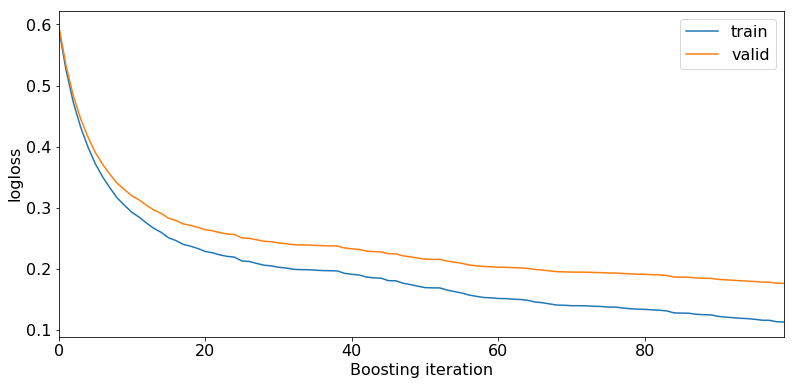

In [190]:
df_score = pd.DataFrame({'train':evals_result['train']['logloss'],
                         'valid':evals_result['valid']['logloss']})
df_score.plot(figsize=(13, 6))
plt.ylabel("logloss")
plt.xlabel("Boosting iteration")

In [191]:
baseline = df_score.valid.iloc[-1]

In [192]:
params_xgb.update({'process_type':'update',
                   'updater':'refresh',
                   'refresh_leaf': True})

In [193]:
r_lst = [0.5, 0.8, 1, 2, 4, 8]

In [194]:
print("Refreshing ...")
idx_base = np.arange(N)
pr_dict = {}
for r in r_lst:
    t0 = time.time()
    pr_lst = []
    for i in range(10):
        idx = np.random.choice(idx_base, int(r * N), replace=True)
        xgmat_sample = xgb.DMatrix(X[idx], label=y[idx], feature_names=feature_names)
        bst_after = xgb.train(params_xgb, xgmat_sample, n_rounds, xgb_model=bst)
        pr_lst.append(bst_after.predict(xgmat_valid))
    pr_dict[r] = pr_lst
    print("r:%.1f, %.1fs" % (r, (time.time() - t0)))

Refreshing ...
r:0.5, 3.9s
r:0.8, 5.7s
r:1.0, 6.7s
r:2.0, 12.3s
r:4.0, 23.4s
r:8.0, 45.5s


In [195]:
df_scores = pd.DataFrame(index=range(10))
for r in r_lst:
    pr_lst = pr_dict[r]
    pr_avg = np.zeros(y_valid.size)
    scores = []
    for i in range(10):
        pr = pr_lst[i]
        pr_avg += pr
        scores.append({'one_%.1f' % r:log_loss(y_valid, pr),
                       'avg_%.1f' % r:log_loss(y_valid, pr_avg/(i+1)),
                      })
    df_scores = df_scores.join(pd.DataFrame(scores))

/usr/lib/python3/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:
/usr/lib/python3/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


In [196]:
baseline

0.17676600000000001

In [197]:
df_scores.iloc[:, ::2].tail(1)

,avg_0.5,avg_0.8,avg_1.0,avg_2.0,avg_4.0,avg_8.0
9,0.186526,0.180568,0.178471,0.174201,0.172343,0.17126


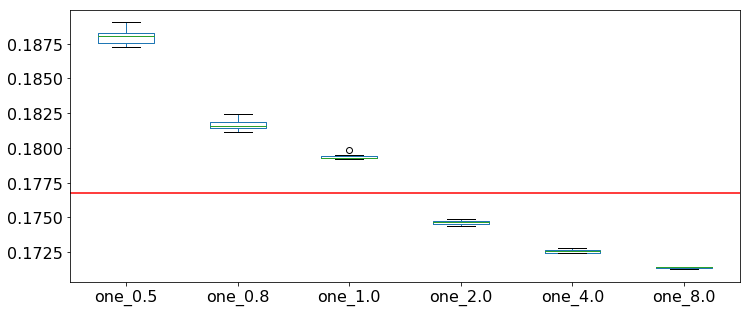

In [198]:
df_scores.iloc[:,1::2].plot(kind='box', figsize=(12,5))
plt.axhline(y=baseline, color='red')